# Task
Evaluate cold posterior effect using Variational inference on MNIST (or similar dataset). Plot the model performance from the temperature.

The cold posterior effect:
\begin{equation}
\mathrm{P}(\mathbf{w} \mid \mathbf{y}, \mathbf{X}) \propto \mathrm{P}(\mathbf{w}) \mathrm{P}(\mathbf{y} \mid \mathbf{w}, \mathbf{X}) \tag{1}
\end{equation}
Better performance when using a “cold” posterior:
\begin{equation*}
\mathrm{Q}(\mathbf{w}) \propto(\mathrm{P}(\mathbf{w}) \mathrm{P}(\mathbf{y} \mid \mathbf{w}, \mathbf{X}))^{1 / T} \tag{2} \text{, where $T<1$.}
\end{equation*}

Code based on https://github.com/activatedgeek/understanding-bayesian-classification .

## Librarires, seed and device

In [27]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List
from torch import Tensor
import math
from torch.optim import SGD
import random
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.distributions import Normal, Categorical, Dirichlet, kl_divergence

from torch.distributions.mixture_same_family import MixtureSameFamily

In [28]:
import random

def set_seeds(seed=None):
  if seed is not None and seed >= 0:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [30]:
# Load dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [31]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(1024, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, inputs):
        return self.net(inputs)

##SGLD

In [32]:
def sgld(params: List[Tensor],
         d_p_list: List[Tensor],
         momentum_buffer_list: List[Tensor],
         *,
         weight_decay: float,
         lr: float,
         momentum: float,
         noise: bool,
         temperature: float):
    r"""Functional API for SGMCMC/SGHMC.

    .. _SGLD\: Bayesian Learning via Stochastic Gradient Langevin Dynamics:
          https://icml.cc/2011/papers/398_icmlpaper.pdf
    .. _SGHMC\: Stochastic Gradient Hamiltonian Monte Carlo:
          http://www.istc-cc.cmu.edu/publications/papers/2014/Guestrin-stochastic-gradient.pdf
    """

    for i, param in enumerate(params):

        d_p = d_p_list[i]

        if weight_decay != 0:
            d_p.add_(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            buf.mul_(1 - momentum).add_(d_p, alpha=-lr)
            if noise:
                eps = torch.randn_like(d_p)
                buf.add_(eps, alpha=math.sqrt(2 * lr * momentum * temperature))

            param.add_(buf)
        else:
            param.add_(d_p, alpha=-lr)

            if noise:
                eps = torch.randn_like(d_p)
                param.add_(eps, alpha=math.sqrt(2 * lr * temperature))


class SGLD(SGD):
    """Implements SGLD/SGHMC updates.

    Assumes negative log density.

    SGHMC updates are used for non-zero momentum values. The gradient noise
    variance is assumed to be zero. Mass matrix is kept to be identity.

    WARN: The variance estimate of gradients is assumed to be zero for SGHMC.
    """
    def __init__(self, *args, momentum=0, temperature=1, **kwargs):
        super().__init__(*args, momentum=momentum, **kwargs)

        self.T = temperature
        if momentum != 0:
            self.reset_momentum()

    @torch.no_grad()
    def step(self, closure=None, noise=True):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgld(params_with_grad,
                 d_p_list,
                 momentum_buffer_list,
                 weight_decay=weight_decay,
                 lr=lr,
                 momentum=momentum,
                 noise=noise,
                 temperature=self.T)

            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

    @torch.no_grad()
    def reset_momentum(self):
        for group in self.param_groups:
            momentum = group['momentum']

            assert momentum > 0, "Must use momentum > 0 to use SGHMC."

            for p in group['params']:
                state = self.state[p]
                state['momentum_buffer'] = torch.zeros_like(p)

        return self

In [33]:
def run_sgld(train_loader, test_loader, net, criterion, device=None,
             lr=1e-7, momentum=.9, temperature=1,
             epochs=1):
  train_data = train_loader.dataset
  N = len(train_data)

  sgld = SGLD(net.parameters(), lr=lr, momentum=momentum, temperature=temperature)
  # sample_int = (epochs - burn_in) // n_samples

  for e in tqdm(range(epochs)):
    net.train()
    for i, (X, Y) in tqdm(enumerate(train_loader), leave=False):
      X, Y = X.to(device).to(device), Y.to(device)

      sgld.zero_grad()

      f_hat = net(X)

      loss = criterion(f_hat, Y, N=N, diri=False)

      loss.backward()

      sgld.step()
    test_metrics = test(test_loader, net, criterion, device=device)
    # print(test_metrics)
  return test_metrics['acc']

## Test function

In [34]:
@torch.no_grad()
def test(data_loader, net, criterion, device=None):
  net.eval()

  total_loss = 0.
  N = 0
  Nc = 0

  for X, Y in tqdm(data_loader, leave=False):
    X, Y = X.to(device), Y.to(device)

    f_hat = net(X)
    Y_pred = f_hat.argmax(dim=-1)
    loss = criterion(f_hat, Y, N=X.size(0))

    N += Y.size(0)
    Nc += (Y_pred == Y).sum().item()
    total_loss += loss

  acc = Nc / N

  return {
    'total_loss': total_loss.item(),
    'acc': acc,
  }

In [35]:
class CPriorAugmentedCELoss(nn.Module):
  '''Standard CrossEntropy + Gaussian prior + Dirichlet Logits Data Prior.
  '''
  def __init__(self, params, prior_scale=1, logits_temp=1, dir_noise=1e-4):
    super().__init__()

    self.theta = params
    self.sigma = prior_scale
    self.logits_T = logits_temp
    self.alpha_eps = dir_noise

    self.ce = nn.CrossEntropyLoss()

  def forward(self, logits, Y, N=1, diri=False):
    energy = self.ce(logits, Y).mul(N)

    if diri:
      cprior = Dirichlet(torch.ones(logits.size(-1), device=logits.device) * self.alpha_eps)
      energy -= cprior.log_prob(logits.softmax(dim=-1)).mean().mul(N)

      energy += (logits * (self.alpha_eps - 1)).mean().mul(N)

    for p in self.theta:
      prior = Normal(torch.zeros_like(p), self.sigma)
      energy -= prior.log_prob(p).sum()

    return energy

## Evaluation

In [38]:
def main(seed=None, device=0, train_loader=None, test_loader=None, net=None,
         prior_scale=1,
         noise=1e-4,
         sgld_epochs=0, sgld_lr=1e-6, momentum=.9, temperature=1):

  # torch.backends.cudnn.benchmark = True
  set_seeds(seed)
  device = f"cuda:{device}" if (device >= 0 and torch.cuda.is_available()) else "cpu"
  net = net.to(device)
  nll_criterion = None
  criterion = CPriorAugmentedCELoss(net.parameters(), prior_scale=prior_scale, dir_noise=noise,
                                    logits_temp=temperature)

  return run_sgld(train_loader, test_loader, net, criterion, device=device,
                lr=sgld_lr, momentum=momentum, temperature=1., epochs=sgld_epochs)


In [39]:
temperatures = [1, 1e-1, 1e-2, 1e-3, 1e-4]
performances = []

In [40]:
temperatures = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
performances = []
for temp in temperatures:
  x = main(seed=0, device=0, train_loader=train_loader, test_loader=test_loader, net=LeNet(),
            prior_scale=1,
            noise=1e-4,
            sgld_epochs=10, sgld_lr=1e-6, momentum=.9, temperature=temp)
  performances.append(x)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

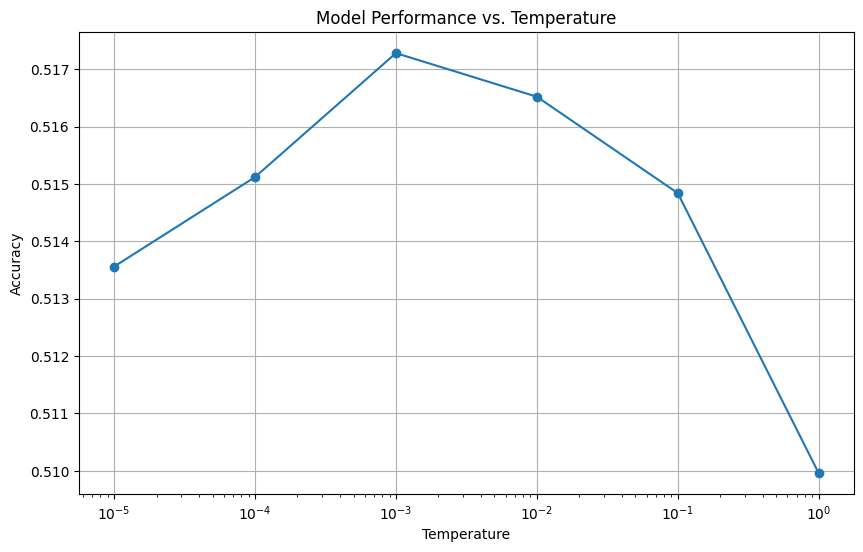

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, performances, marker='o')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Model Performance vs. Temperature')
plt.xscale('log')
plt.grid(True)
plt.show()

## MNIST

In [42]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5463729.11it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160196.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1514608.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3048084.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [43]:
class LeNetMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, inputs):
        return self.net(inputs)

In [44]:
temperatures = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
performances = []
for temp in temperatures:
  x = main(seed=0, device=0, train_loader=train_loader, test_loader=test_loader, net=LeNetMNIST(),
            prior_scale=1,
            noise=1e-4,
            sgld_epochs=5, sgld_lr=1e-6, momentum=.9, temperature=temp)
  performances.append(x)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

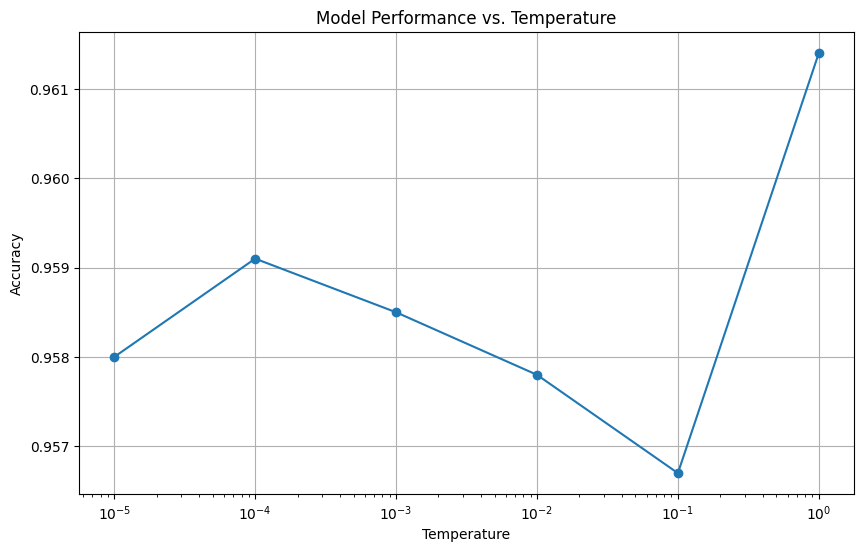

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, performances, marker='o')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Model Performance vs. Temperature')
plt.xscale('log')
plt.grid(True)
plt.show()